In [14]:
#Required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

In [15]:
#Simple PINN architecture to solve the ODE y''=-(\pi/5)^2*y.
class ODE2(nn.Module):
    def __init__(self, in_d, layer):
        super(ODE2,self).__init__()
        self.nlp=nn.Sequential(
            nn.Linear(in_d, layer),
            nn.Tanh(),
            nn.Linear(layer, layer),
            nn.Tanh(),
            nn.Linear(layer, layer),
            nn.Tanh(),
            nn.Linear(layer, layer),
            nn.Tanh(),
            nn.Linear(layer, in_d)
        )

    def forward(self,x):
        return self.nlp(x)

In [16]:
#Setting for the training. We impose the boundary conditions at 0 (point1) and we choose for the training a grid of 200 points in the interval [0,20]
torch.manual_seed(23)
trial= ODE2(1,30)

data=torch.linspace(0,20,200).view(200,-1).requires_grad_(True)

point1=torch.Tensor([0]).reshape(1,1).requires_grad_(True)

In [17]:
#Function for plotting the analytic and numeric solutions in the range [0,33.3].
def plot_graph(trial, const):
    domain=torch.arange(1000)/30
    domain=domain.reshape(1000,-1)
    numeric=[x.item() for x in const+trial(domain)]
    f_an=2*torch.cos(np.pi*domain/5)
    analytic=[x.item() for x in f_an]

    plt.plot(numeric, label='Numeric', color='b')
    plt.plot(analytic, label='Analytic', color='r')
    plt.legend()
    plt.show()

Epoch 0, Loss 0.013814849779009819


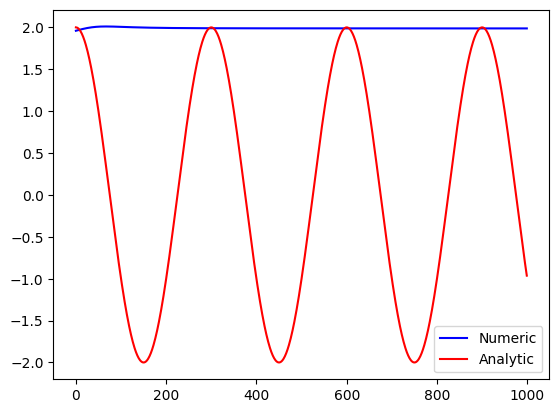

Epoch 3000, Loss 3.6551955417962745e-05
Epoch 6000, Loss 3.553143687895499e-05
Epoch 9000, Loss 5.161705121281557e-05
Epoch 12000, Loss 2.6013040042016655e-05
Epoch 15000, Loss 2.0012512322864495e-05
Epoch 18000, Loss 3.885359546984546e-05
Epoch 21000, Loss 1.8070091755362228e-05
Epoch 24000, Loss 2.2477510356111452e-05
Epoch 27000, Loss 1.918883208418265e-05
Epoch 30000, Loss 1.803918530640658e-05
Epoch 33000, Loss 6.745680002495646e-05
Epoch 36000, Loss 3.847532570944168e-05
Epoch 39000, Loss 1.2137842531956267e-05
Epoch 42000, Loss 1.2258999959158245e-05
Epoch 45000, Loss 1.102498390537221e-05
Epoch 48000, Loss 1.0313731763744727e-05


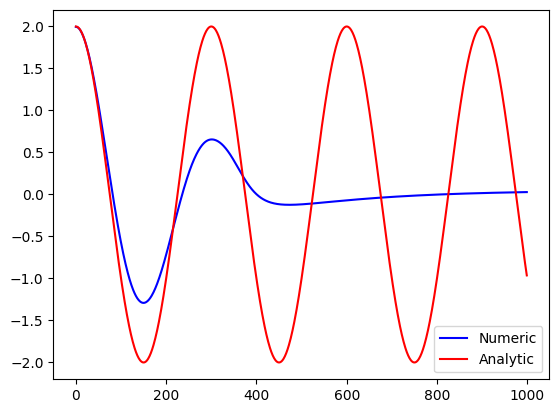

Epoch 51000, Loss 9.899453289108351e-06
Epoch 54000, Loss 1.7060920072253793e-05
Epoch 57000, Loss 2.7508944185683504e-05
Epoch 60000, Loss 1.7273267076234333e-05
Epoch 63000, Loss 8.815188266453333e-06
Epoch 66000, Loss 7.747605195618235e-06
Epoch 69000, Loss 8.054850695771165e-06
Epoch 72000, Loss 5.690044872608269e-06
Epoch 75000, Loss 4.88419982502819e-06
Epoch 78000, Loss 3.5875646062777378e-06
Epoch 81000, Loss 2.9285886284924345e-06
Epoch 84000, Loss 2.440594698782661e-06
Epoch 87000, Loss 2.5383733373018913e-06
Epoch 90000, Loss 4.1868715925375e-06
Epoch 93000, Loss 1.104264583773329e-06
Epoch 96000, Loss 1.6233368569373852e-06
Epoch 99000, Loss 1.5312513141907402e-06


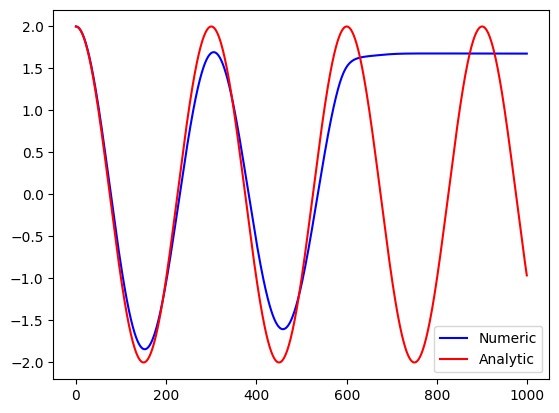

Epoch 102000, Loss 9.881853202386992e-07
Epoch 105000, Loss 7.594897510898591e-07
Epoch 108000, Loss 1.3565190783992875e-06
Epoch 111000, Loss 5.622620392387034e-06
Epoch 114000, Loss 4.1015334772964707e-07
Epoch 117000, Loss 1.8271881572218263e-06
Epoch 120000, Loss 1.7739668578542478e-07
Epoch 123000, Loss 9.40125858051033e-07
Epoch 126000, Loss 8.879217602952849e-06
Epoch 129000, Loss 2.0972173331301747e-07
Epoch 132000, Loss 4.466548034542939e-06
Epoch 135000, Loss 4.777816684509162e-07
Epoch 138000, Loss 5.6209056964462434e-08
Epoch 141000, Loss 9.983554605241807e-08
Epoch 144000, Loss 5.039551979280077e-06
Epoch 147000, Loss 1.744408884007953e-08


In [18]:
# In the loss function we add the boundary conditions y(0)=2 and y'(0)=0
# The settings for the training have been found starting from those of known PINNs and optimizing for the problem at hand
# We plot the graphs of exact and numeric solutions every 50000 epochs
optimizer=optim.Adam(trial.parameters(), lr=0.0015, betas=(0.9, 0.999))

epochs=150000
const=2
error=[]
for i in range(epochs):  
    der=torch.autograd.grad(trial(point1), point1, torch.ones_like(trial(point1)), create_graph=True)[0]
    optimizer.zero_grad()
    y=const+trial(data)
    der1=torch.autograd.grad(y.reshape(-1,1), data, torch.ones_like(y), create_graph=True)[0]
    der2=torch.autograd.grad(der1, data, torch.ones_like(der1), create_graph=True)[0]
    loss=0.001*nn.MSELoss()(torch.flatten(der2), -(np.pi**2/25)*torch.flatten(y))+1*(trial(point1))**2+1*(der)**2
    error.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(trial.parameters(), max_norm=0.1, norm_type=2.0, error_if_nonfinite=False)
    optimizer.step()
    if i%3000==0:
        print(f"Epoch {i}, Loss {error[-1]}")
    if i%50000==0:
        plot_graph(trial, const)

#plt.plot(error)
#plt.show()

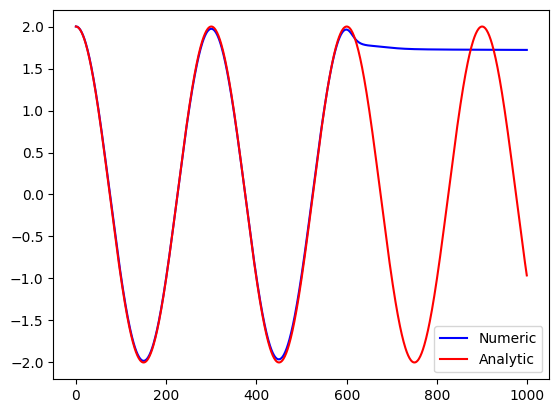

In [19]:
#We plot the analytic and trained numeric solutions in the range [0,33.3]. In the training range [0,20] the two essentially coincide
plot_graph(trial, const)

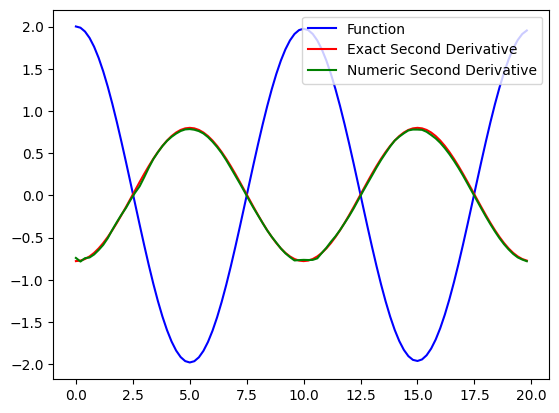

In [21]:
#We plot in the dotraining domain [0,20] the analytic function, its second derivative and the second derivative of the numeric solution.
a=(torch.arange(100)/5).view(-1,1).requires_grad_(True)
y=const+trial(a)
f_an=2*torch.cos(np.pi*a/5)
c=[x.item()+0.01 for x in -(np.pi**2/25)*f_an]
der1=[torch.autograd.grad(outputs=out, inputs=a, retain_graph=True, create_graph=True)[0][i] for i, out in enumerate(y.reshape(-1,1))]
der2=[torch.autograd.grad(outputs=out, inputs=a, retain_graph=True)[0][i] for i, out in enumerate(der1)]

plt.plot(a.detach().numpy(),y.detach().numpy(), label='Function', color='b')
plt.plot(a.detach().numpy(),c, label='Exact Second Derivative', color='r')
plt.plot(a.detach().numpy(),der2, label='Numeric Second Derivative', color='g')
plt.legend()
plt.show()